In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import pacakages
---

In [125]:
# Basic tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D

# DL tools
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Device Setting
---

In [126]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


# Function
---

In [127]:
'''
# function_2d
# Input : x , y
# output : z = f(x,y)
'''
def function_2d(x,y):
  term_sqrt = np.sqrt(x*x+y*y)
  term1 = np.sin(20*term_sqrt)/(20*term_sqrt)
  term2 = (1/5)*np.cos(10*term_sqrt)
  term3 = y/2 - 0.3
  label = term1 + term2 + term3
  return label

'''
# generate_data
# input : dim (int)
# output : (10000, 3) dataset, type : np.array
- first column : x
- second column : y
- third column : f(x,y) (True label)
'''
def generate_data(dim):
  x = np.linspace(-1, 1, dim)
  y = np.linspace(-1, 1, dim)
  xx, yy = np.meshgrid(x,y)
  zz = function_2d(xx,yy)
  data_1 = xx.reshape(-1,1)
  data_2 = yy.reshape(-1,1)
  label = zz.reshape(-1,1)
  dataset = np.hstack((data_1, data_2))
  dataset = np.hstack((dataset, label))
  return dataset

# Function Plot
---

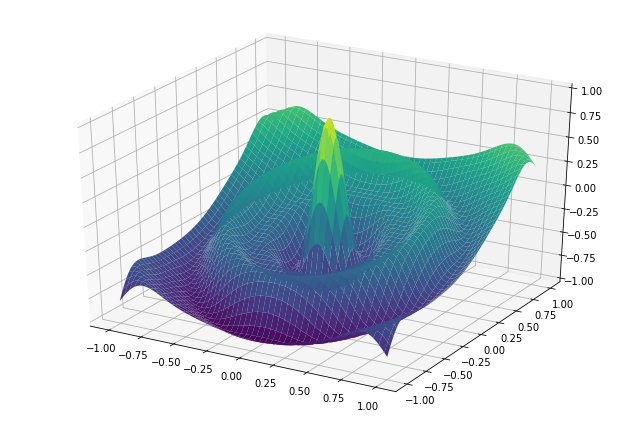

In [128]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x,y)
zz = function_2d(xx,yy)
surf = ax.plot_surface(xx, yy, zz, cmap='viridis')
surf.set_clim(-1.0, 1.0)
ax.view_init(30,-60)
ax.set_zticks([-1,1])
ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
plt.tight_layout()
plt.show()

# Data Load
---

In [129]:
class Mydataset(torch.utils.data.Dataset):
  def __init__(self, dataX_np , dataY_np):
    self.data_X = dataX_np.astype(np.float32)
    self.data_Y = dataY_np.astype(np.float32)
    print(f"My_dataset __init__ received : {self.data_X.shape}, {self.data_Y.shape} ")
  def __getitem__(self, index):
    batch = self.data_X[index]
    target = self.data_Y[index]
    return batch, target
  def __len__(self):
    return len(self.data_X)


In [130]:
dataset = generate_data(100)

In [131]:
x = dataset[:, :2]
y = dataset[:,2:]
# train-temp 분리 (7:3)
x_train, x_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3, shuffle=True)
# temp 에서 validation-test 분리 3 -> 1.5:1.5
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,shuffle=True)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(7000, 2)
(1500, 2)
(1500, 2)
(1500, 1)


# Model
---

In [158]:
class SimpleMLP(nn.Module):
    def __init__(self, inp_ = 2, output_ = 1):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(inp_, 56)
        self.fc2 = nn.Linear(56, 28)
        self.fc3 = nn.Linear(28, output_)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)

        return x

In [159]:
batch_size = 1000000
train_loader = torch.utils.data.DataLoader(Mydataset(x_train, y_train), batch_size=batch_size, shuffle=False, drop_last = False)
valid_loader = torch.utils.data.DataLoader(Mydataset(x_val, y_val), batch_size=batch_size, shuffle=False, drop_last = False)
test_loader = torch.utils.data.DataLoader(Mydataset(x_test, y_test), batch_size=batch_size, shuffle=False, drop_last = False)

My_dataset __init__ received : (7000, 2), (7000, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 
My_dataset __init__ received : (1500, 2), (1500, 1) 


# Train
---

In [160]:
from statistics import mean 
import time

def train(model, criterion_, optimizer_, scheduler_, num_epochs=40, first_epoch=1):
    
    train_losses = []
    valid_losses = []
    test_losses = []

    print("----------------------------------------------------------------------------")

    start_time = time.time()
    for epoch in range(first_epoch, first_epoch + num_epochs):
        # train phase
        model.train()
        
        # batch_loss 
        batch_losses = []

        for images, labels in train_loader:
            
            # Move the training data to the GPU
            images = images.to(device)   
            labels = labels.to(device)

            # clear previous gradient computation
            optimizer_.zero_grad()

            # forward propagation
            outputs = model(images)

            # calculate the loss
            loss = criterion_.forward(outputs, labels)
            batch_losses.append(loss.item())

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer_.step()

        # Train loss를 저장합니다.
        train_losses.append(mean(batch_losses))

        # validation phase
        # Dropout, BatchNormalization과 같은 layer가 동작하지 않도록 합니다.
        model.eval()

        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        # 기울기 Gradient를 계산하지 않으며 backpropagation을 하지 않습니다. 
        with torch.no_grad():
            
            correct_test = 0

            for images, labels in valid_loader:

                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                valid_losses.append(loss.item())

            for images, labels in test_loader:
                # Move the training batch to the GPU
                images = images.to(device)
                labels = labels.to(device)

                # forward propagation
                outputs = model(images)

                # calculate the loss
                loss = criterion_(outputs, labels)
                test_losses.append(loss.item())

                # Check Accuracy
                # preds 는 output 중에서 가장 높은 값의 index를 가집니다. 
                _, preds = torch.max(outputs, 1)

                # label이 현재 one hot encoding 형태로 되어있기에 preds를 index로 받아 1인지 확인합니다. 
                # ex) 숫자 2 : label = [0,0,1,0,0,...,0] , label[i][preds] == 1 -> 정답
                for i in range(len(preds)):
                  if labels[i][preds[i]] == 1:
                    correct_test +=1
        
        # 원하는 Epoch마다 결과 출력 
        if (epoch) % 1000 == 0 :
            curr_time = round(time.time()-start_time)
            train_rec = round(train_losses[-1],5)
            valid_rec = round(valid_losses[-1],5)
            test_rec = round(test_losses[-1],5)
            test_acc = round(100*(correct_test)/len(labels),3)
            print('Epoch', epoch, ' / ',num_epochs)
            print(f"\t [Train loss : {train_rec}]  [Validation loss : {valid_rec}] [Test loss : {test_rec}], [Test Accuracy : {test_acc}%],[curr LR = {scheduler_.get_last_lr()}],[elapsed_time = {curr_time}sec] ")

        # Learning rate Scheduling
        # Scheduler에 따라 learning rate를 조절합니다. 
        scheduler_.step()
        
      
    print(f"\nTrain Ended, total_elapsed_time = {round(time.time()-start_time)} ")
    print("--------------------------------------------------------------------")
    
    # Loss 값 반환
    return train_losses, valid_losses, test_losses

## Training

In [161]:
model = SimpleMLP()
model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

In [146]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
	 [Train loss : 0.02819]  [Validation loss : 0.02804] [Test loss : 0.02951], [Test Accuracy : 0.0%],[curr LR = [0.0125]],[elapsed_time = 1281sec] 
Epoch 7503  /  10000
	 [Train loss : 0.02819]  [Validation loss : 0.02804] [Test loss : 0.02951], [Test Accuracy : 0.0%],[curr LR = [0.0125]],[elapsed_time = 1281sec] 
Epoch 7504  /  10000
	 [Train loss : 0.02818]  [Validation loss : 0.02804] [Test loss : 0.02951], [Test Accuracy : 0.0%],[curr LR = [0.0125]],[elapsed_time = 1281sec] 
Epoch 7505  /  10000
	 [Train loss : 0.02818]  [Validation loss : 0.02804] [Test loss : 0.02951], [Test Accuracy : 0.0%],[curr LR = [0.0125]],[elapsed_time = 1282sec] 
Epoch 7506  /  10000
	 [Train loss : 0.02818]  [Validation loss : 0.02804] [Test loss : 0.02951], [Test Accuracy : 0.0%],[curr LR = [0.0125]],[elapsed_time = 1282sec] 
Epoch 7507  /  10000
	 [Train loss : 0.02818]  [Validation loss : 0.02804] [Test loss : 0.02951], [Test Accuracy : 0.0%],[curr LR = [0.0125]],[el

In [155]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

----------------------------------------------------------------------------
Epoch 1000  /  10000
	 [Train loss : 0.11466]  [Validation loss : 0.12068] [Test loss : 0.11538], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 181sec] 
Epoch 2000  /  10000
	 [Train loss : 5.54517]  [Validation loss : 9.99638] [Test loss : 9.94852], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 361sec] 
Epoch 3000  /  10000
	 [Train loss : 0.11466]  [Validation loss : 0.12068] [Test loss : 0.11538], [Test Accuracy : 0.0%],[curr LR = [0.05]],[elapsed_time = 539sec] 
Epoch 4000  /  10000
	 [Train loss : 0.11466]  [Validation loss : 0.12066] [Test loss : 0.11537], [Test Accuracy : 0.0%],[curr LR = [0.05]],[elapsed_time = 718sec] 
Epoch 5000  /  10000
	 [Train loss : 0.11466]  [Validation loss : 0.12068] [Test loss : 0.11538], [Test Accuracy : 0.0%],[curr LR = [0.025]],[elapsed_time = 902sec] 
Epoch 6000  /  10000
	 [Train loss : 0.11466]  [Validation loss : 0.12068] [Test loss : 0.11538], [

In [162]:
train_losses, valid_losses, test_losses = train(model, criterion_ = criterion, optimizer_ = optimizer, scheduler_ = scheduler, num_epochs=10000)

----------------------------------------------------------------------------
Epoch 1000  /  10000
	 [Train loss : 0.00227]  [Validation loss : 0.00216] [Test loss : 0.00233], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 165sec] 
Epoch 2000  /  10000
	 [Train loss : 0.00123]  [Validation loss : 0.0012] [Test loss : 0.00128], [Test Accuracy : 0.0%],[curr LR = [0.1]],[elapsed_time = 328sec] 
Epoch 3000  /  10000
	 [Train loss : 0.00078]  [Validation loss : 0.00073] [Test loss : 0.00078], [Test Accuracy : 0.0%],[curr LR = [0.05]],[elapsed_time = 491sec] 
Epoch 4000  /  10000
	 [Train loss : 0.00084]  [Validation loss : 0.00095] [Test loss : 0.00101], [Test Accuracy : 0.0%],[curr LR = [0.05]],[elapsed_time = 654sec] 
Epoch 5000  /  10000
	 [Train loss : 0.00046]  [Validation loss : 0.00045] [Test loss : 0.00051], [Test Accuracy : 0.0%],[curr LR = [0.025]],[elapsed_time = 817sec] 
Epoch 6000  /  10000
	 [Train loss : 0.0004]  [Validation loss : 0.00039] [Test loss : 0.00044], [Te

# Plot Result
---

In [147]:
def plot_result(train_loss, val_loss, test_loss):
  plt.figure(figsize=(20,8))
  plt.plot(train_loss, label='Train Loss', linewidth='3')
  plt.plot(val_loss, label='Validation Loss', linewidth='3')
  plt.plot(test_loss, label='Test Loss', linewidth='3')
  plt.grid()
  plt.rc('xtick', labelsize=12)
  plt.rc('ytick', labelsize=12)  
  plt.legend()
  plt.rc('legend', fontsize=15)  
  plt.xlabel('Number of Eopch')
  plt.ylabel('Cross Entropy Loss')
  plt.rc('axes', labelsize=17)  


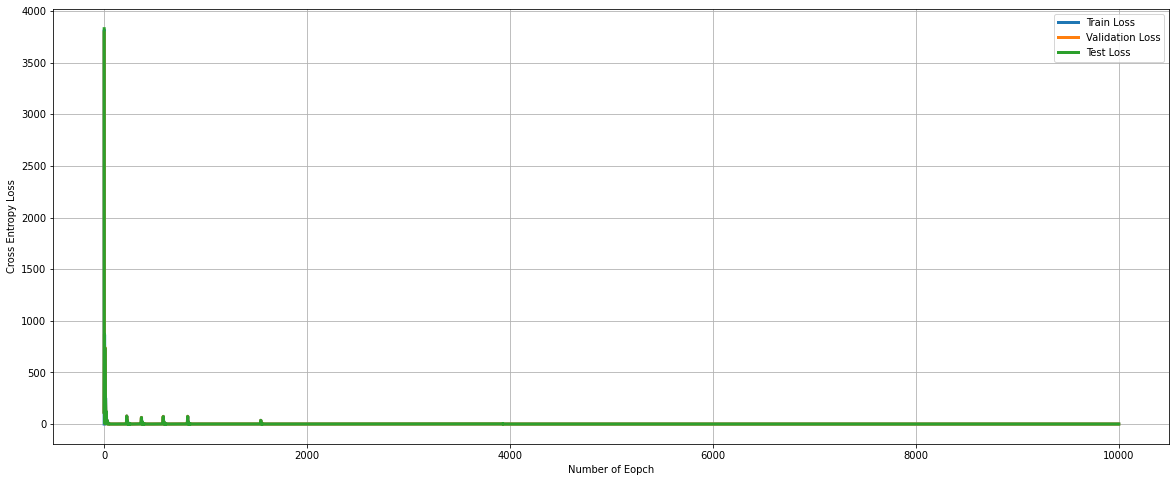

In [148]:
plot_result(train_losses, valid_losses, test_losses)

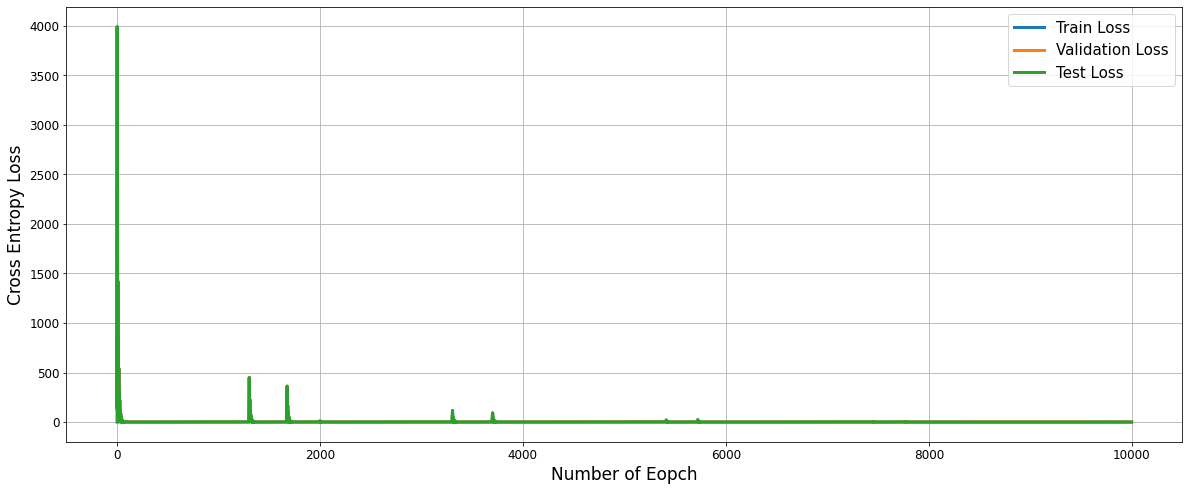

In [156]:
plot_result(train_losses, valid_losses, test_losses)

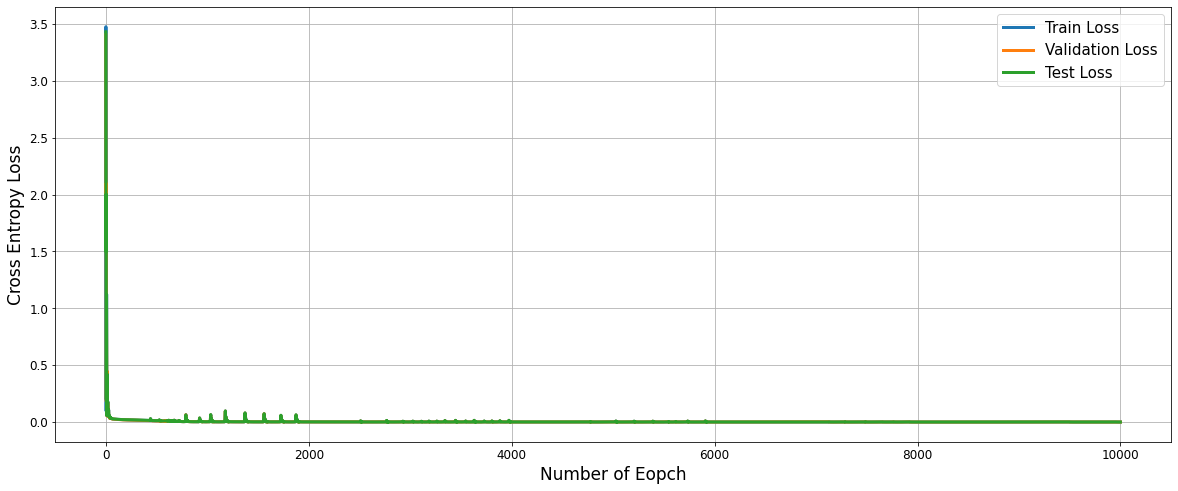

In [163]:
plot_result(train_losses, valid_losses, test_losses)

#Graph

In [149]:
def visual_graph(model):
  x = np.linspace(-1, 1, 100)
  y = np.linspace(-1, 1, 100)
  xx,yy = np.meshgrid(x,y)
  xx = xx.reshape(-1,1)
  yy = yy.reshape(-1,1)
  inp_np = np.hstack((xx,yy))
  inp_tensor = torch.Tensor(inp_np)
  inp_tensor = inp_tensor.to(device)
  zz = model(inp_tensor)
  pred_output = zz.detach().cpu().numpy()
  fig = plt.figure(figsize=(9, 6))
  ax = fig.add_subplot(111, projection='3d')
  xx = xx.reshape(100,100)
  yy = yy.reshape(100,100)
  pred_output = pred_output.reshape(100,100)
  surf = ax.plot_surface(xx, yy, pred_output, cmap='viridis')
  surf.set_clim(-1.0, 1.0)
  ax.view_init(30,-60)
  ax.set_zticks([-1,1])
  ax.zaxis.set_major_locator(ticker.MultipleLocator(0.25))
  plt.tight_layout()
  plt.show()

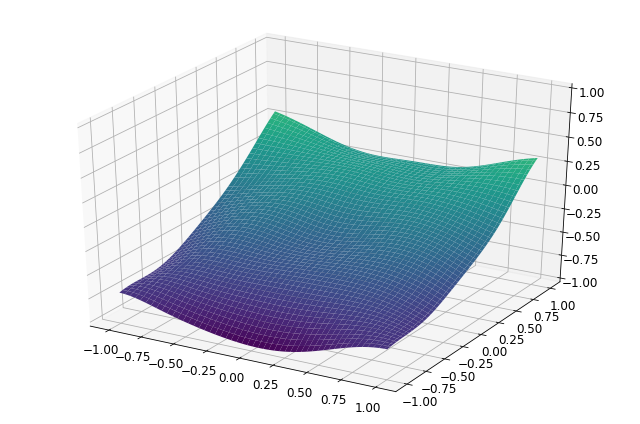

In [150]:
visual_graph(model)

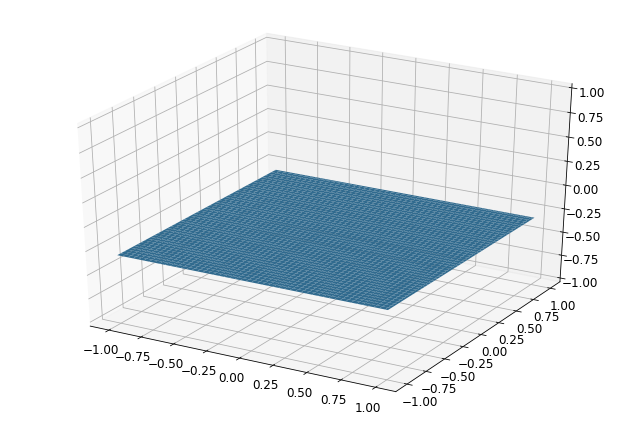

In [157]:
visual_graph(model)

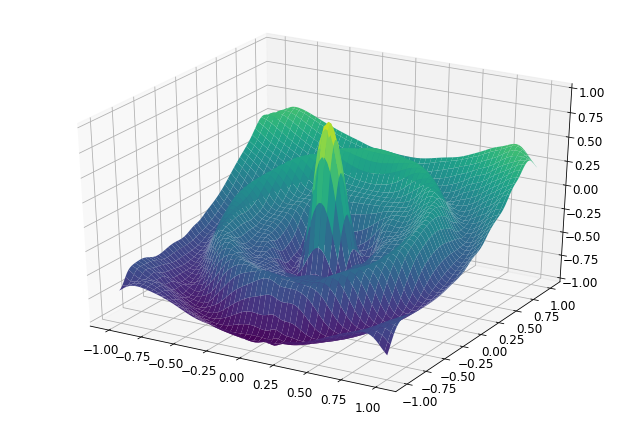

In [164]:
visual_graph(model)